In [1]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import numpy as np
import re
import sys

In [3]:
sys.path.append('../../..')
import utils

In [4]:
labels = {
    'min_total_duration': 'Makespan+perf',
    'gandiva': 'Gandiva',
}

In [5]:
def parse_logfile_debug(logfile):
    num_rounds = {}
    with open(logfile, 'r') as f:
        current_round = 0
        round_start = False
        for line in f:
            if 'Micro-task scheduled' in line:
                if not round_start:
                    round_start = True
                    print('Round %d' % (current_round))
                match = re.search('Job ID: (\d+).*Worker type: (\w+)\tWorker ID\(s\): (.*)\tPriority', line)
                assert match is not None
                job_id = int(match.group(1))
                worker_type = match.group(2)
                worker_ids =  match.group(3)
                if job_id not in num_rounds:
                    num_rounds[job_id] = {}
                    for worker_type in ['k80', 'p100', 'v100']:
                        num_rounds[job_id][worker_type] = 0
                num_rounds[job_id][worker_type] += 1
                print('Job %d\tworker type: %s\tWorker IDs: %s' % (job_id, worker_type, worker_ids))
            elif round_start:
                current_round += 1
                print('')
                round_start = False
    
    for job_id in sorted(num_rounds.keys()):
        print('Job %d: %d K80\t%d P100\t%d V100' % (
            job_id, num_rounds[job_id]['k80'],
            num_rounds[job_id]['p100'], num_rounds[job_id]['v100']))

In [6]:
def get_jcts_from_logfile(logfile):
    jcts = {}
    with open(logfile, 'r') as f:
        collect_jcts = False
        for line in f:
            if line.strip() == 'Job completion times:':
                collect_jcts = True
                continue
            if collect_jcts:
                match = re.match('Job (\d+): (\d+\.\d+)', line.strip())
                if match is not None:
                    job_id = int(match.group(1))
                    jct = float(match.group(2))
                    jcts[job_id] = jct
                else:
                    return jcts

In [7]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [8]:
jobs, arrival_times = utils.parse_trace(
    ('/lfs/1/deepak/gpusched/scheduler/traces/'
     'physical_cluster/minimize_makespan.trace'))

In [9]:
def get_ratios(real_jcts, simulation_jcts):
    ratios = []
    for job_id in sorted(simulation_jcts.keys()):
        ratios.append(real_jcts[job_id] / simulation_jcts[job_id])
    return ratios

In [10]:
def print_sorted_ratios(ratios):
    jobs_and_ratios = []
    for i, (job, ratio) in enumerate(zip(jobs, ratios)):
        jobs_and_ratios.append((i, job.job_type, ratio))
    jobs_and_ratios.sort(key=lambda x: x[-1])
    for (job_id, job_type, ratio) in jobs_and_ratios:
        print('Job %d (%s): real / simulation: %.2fx' % (job_id, job_type, ratio))

In [11]:
def plot_ratios(all_ratios, policies, output_filename=None):
    plt.figure(figsize=(4.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    for (ratios, policy) in zip(all_ratios, policies):
        data, p = get_cdf(ratios)
        ax.plot(data, p, label=labels[policy])
    ax.set_xlabel('Real JCT / Simulation JCT')
    ax.set_ylabel('Fraction of jobs')
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks([0.5, 1.0, 1.5, 2.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    leg = plt.legend(frameon=False, ncol=2, loc='upper center')
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.25
    bb.y1 += 0.25
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    sns.despine()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')

In [12]:
def print_ratios_and_plot(policies, output_filename):
    all_ratios = []
    for policy in policies:
        simulation_logfile = (
            '/lfs/1/deepak/gpusched/scheduler/logs/'
            'physical_cluster_experiments_final/%s/simulation.log') % policy
        real_logfile = (
            '/lfs/1/deepak/gpusched/scheduler/logs/'
            'physical_cluster_experiments_final/%s/server.log') % (policy)
        simulation_jcts = get_jcts_from_logfile(simulation_logfile)
        real_jcts = get_jcts_from_logfile(real_logfile)
        ratios = get_ratios(simulation_jcts, real_jcts)
        all_ratios.append(ratios)
        print(labels[policy])
        print_sorted_ratios(ratios)
        print()
    plot_ratios(all_ratios, policies,
                output_filename=output_filename)

Makespan+perf
Job 64 (Recommendation (batch size 4096)): real / simulation: 0.65x
Job 30 (Recommendation (batch size 4096)): real / simulation: 0.86x
Job 21 (CycleGAN): real / simulation: 0.89x
Job 4 (ResNet-50 (batch size 128)): real / simulation: 0.95x
Job 47 (ResNet-50 (batch size 128)): real / simulation: 0.96x
Job 97 (A3C): real / simulation: 0.97x
Job 43 (LM (batch size 20)): real / simulation: 0.97x
Job 61 (LM (batch size 5)): real / simulation: 0.97x
Job 96 (Transformer (batch size 16)): real / simulation: 0.97x
Job 75 (LM (batch size 20)): real / simulation: 0.98x
Job 66 (Recommendation (batch size 2048)): real / simulation: 0.99x
Job 77 (ResNet-18 (batch size 64)): real / simulation: 0.99x
Job 37 (Transformer (batch size 64)): real / simulation: 0.99x
Job 81 (LM (batch size 5)): real / simulation: 0.99x
Job 23 (LM (batch size 20)): real / simulation: 1.00x
Job 14 (LM (batch size 10)): real / simulation: 1.00x
Job 46 (LM (batch size 10)): real / simulation: 1.00x
Job 90 (LM (b

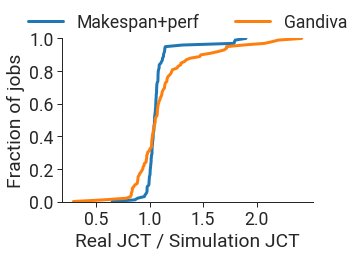

In [13]:
print_ratios_and_plot(['min_total_duration', 'gandiva'],
                      output_filename="physical_cluster_experiments/makespan_cdf_ratios.pdf")